In [4]:
# Imports
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F 
import torchvision.datasets as datasets
from torch.utils.data import Dataset 
from torch.utils.data import random_split 
import torchvision.transforms as transforms 
import os
import shutil
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch import optim
from torch.utils.data import DataLoader 
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from tqdm import tqdm 

from dataGen import Patches
from AlexNet.AlexNet import AlexNet
from PIL import Image
import spectral as spec

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Hyperparameters
in_channels = 14
num_classes = 2
img_size = 227
learning_rate = 0.0001
batch_size = 32
num_epochs = 60

In [7]:
# Transformers
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.ConvertImageDtype(torch.float)])
img_transform

Compose(
    ToTensor()
    Resize(size=(227, 227), interpolation=bilinear)
    ConvertImageDtype()
)

In [9]:
patch = Patches("D:\\gyeongsang_22_10_28\\PATCHES")
patch.describe()

For hdr image, there are: 
 background    12995
leaf           8122
diseased        245
Name: class, dtype: int64
For jpg image, there are: 
 background    12995
leaf           8122
diseased        245
Name: class, dtype: int64


In [25]:
dataset_composition = [
         ['diseased',    245],
         ['leaf',        1300],
         ['background',  1300]]

patch_dataset = patch.generateDataset(
    dataset_composition = dataset_composition,
    data_type = 'hdr')

patch_dataset.loc[(patch_dataset['class'] == 'background'), 'class'] = 0
patch_dataset.loc[(patch_dataset['class'] == 'leaf'), 'class'] = 0
patch_dataset.loc[(patch_dataset['class'] == 'diseased'), 'class'] = 1

patch_dataset.describe()

,path,type,class
count,2845,2845,2845
unique,2845,1,2
top,D:\gyeongsang_22_10_28\PATCHES\MOS_CAL_GEOREF_...,hdr,0
freq,1,2845,2600


In [11]:
# Custom Image Dataset
class Img(Dataset):
    def __init__(self, img_df, transform=None, s=100):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        img = spec.envi.open(img_path)
        np_img = np.array(img[:, :, [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]])
        label = self.img_df['class'].iloc[idx]
        if self.transform:
            image = self.transform(np_img)
        return image, label

In [12]:
dataset = Img(img_df=patch_dataset, transform=img_transform)
# for f in dataset.img_df['path']:
#     print(f)

In [34]:
train_set_num = int(patch_dataset.shape[0] * .7)
val_set_num = patch_dataset.shape[0] - train_set_num

In [35]:
# Load Data
train_dataset, test_dataset = random_split(dataset, [train_set_num, val_set_num])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [36]:
next(iter(train_loader))[0].shape   

torch.Size([32, 14, 227, 227])

In [37]:
def tensorToImg(tensor):
    img = torch.zeros(img_size, img_size, 1)
    for c_y, y in enumerate(tensor[0]):
        for c_x, x in enumerate(y):
            img[c_y][c_x] = x
    return img

In [38]:
def displayImgs(imgs, labels, save=False):
    fig = plt.figure(figsize=(20,11))
    for pos, i in enumerate(imgs[:8]):
        img = tensorToImg(i)
        label = "downy mildew"
        if labels[pos] == 0:
            label = "Non-disease"
        fig.add_subplot(4, 8, pos + 1).title.set_text(label)
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    if save:
        fig.savefig('fig.png')

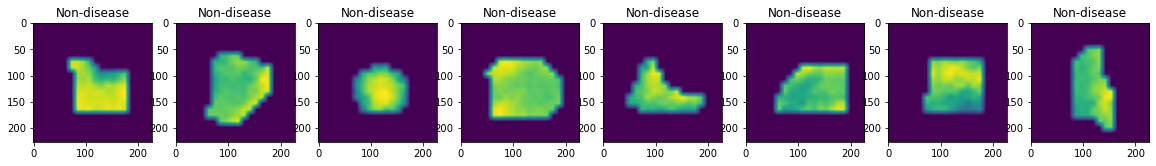

In [39]:
for train_sample in train_loader:
    displayImgs(train_sample[0], train_sample[1], save=True)
    break

In [40]:
# Initialize network
model = AlexNet(in_channels=in_channels, num_classes=num_classes).to(device)

In [16]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)
        print(x_[0])
        break

tensor([-0.0162, -0.0122], device='cuda:0')


In [18]:
# Check accuracy on training & test to see how good our model
def evaluate(loader, model):
    ev = np.zeros(5)
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
                        
            y = y.cpu()
            predictions = predictions.cpu()
                        
            ev[0] += 1
            ev[1] += precision_score(y, predictions)
            ev[2] += recall_score(y, predictions)
            ev[3] += f1_score(y, predictions)
            ev[4] += accuracy_score(y, predictions)
            
        ev = ev/ev[0]
        
    model.train()
    return ev*100

In [19]:
print(f"Accuracy on training set: {evaluate(train_loader, model)}")
print(f"Accuracy on test set: {evaluate(test_loader, model)}")

KeyboardInterrupt: 

In [20]:
history_test = [[] for l in range(6)]
history_train = [[] for l in range(6)]

In [21]:
# Train Network
for epoch in range(num_epochs):
    batch_loss = np.array([])
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        predictions = torch.argmax(scores, dim=1)
               
        #update progess bar
        loop.set_description(f"Epoch[{epoch}/{num_epochs - 1}]")
        
        batch_loss = np.append(batch_loss, loss.item())
    
    history_train[5].append(np.average(batch_loss))
    evaluation_test = evaluate(test_loader, model)
    evaluation_train = evaluate(train_loader, model)
    for i in range(5):
        history_test[i].append(evaluation_test[i])
        history_train[i].append(evaluation_train[i])
        
    print(f"loss: {history_train[5][-1]}\n precision: {history_test[1][-1]}\n recall: {history_test[2][-1]}\n f1 score: {history_test[3][-1]}\n accuracy: {history_test[4][-1]}")

Epoch[0/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:37<00:00,  1.80it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.44764107531484437
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 84.03086763070078


Epoch[1/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.45it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3718811242895968
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 84.03086763070078


Epoch[2/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.354321609963389
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 84.03781979977754


Epoch[3/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.44it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3546747992582181
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 84.0412958843159


Epoch[4/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.45it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3516631019027794
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 84.0412958843159


Epoch[5/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3514753089231603
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 84.03434371523916


Epoch[6/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.45it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.34694118359509635
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 84.0134872080089


Epoch[7/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.33841457568547306
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 84.0273915461624


Epoch[8/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.49it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3421928293126471
 precision: 3.4482758620689653
 recall: 0.6896551724137931
 f1 score: 1.149425287356322
 accuracy: 83.92310901001112


Epoch[9/59]: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.49it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3426733742303708
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 84.03781979977754


Epoch[10/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3429230760563822
 precision: 3.4482758620689653
 recall: 0.8620689655172413
 f1 score: 1.3793103448275863
 accuracy: 83.92310901001112


Epoch[11/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.48it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.33623792669352365
 precision: 37.93103448275862
 recall: 15.008458973976216
 f1 score: 20.324828428276703
 accuracy: 84.36804783092325


Epoch[12/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.48it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3362695662414326
 precision: 27.8735632183908
 recall: 8.680026869682042
 f1 score: 12.611422834546568
 accuracy: 84.58356507230256


Epoch[13/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.45it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.32581196758238706
 precision: 6.896551724137931
 recall: 1.4367816091954022
 f1 score: 2.2546419098143233
 accuracy: 83.59983314794215


Epoch[14/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.32968034704818444
 precision: 34.48275862068966
 recall: 9.396551724137932
 f1 score: 14.152609842265019
 accuracy: 84.58356507230256


Epoch[15/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.42it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.32508151923470635
 precision: 12.068965517241379
 recall: 2.427476737821565
 f1 score: 3.916256157635468
 accuracy: 84.15600667408232


Epoch[16/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.48it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3213007163037272
 precision: 25.57471264367816
 recall: 9.339080459770116
 f1 score: 13.511966960242821
 accuracy: 84.77474972191324


Epoch[17/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.32081686562913303
 precision: 3.4482758620689653
 recall: 0.5747126436781609
 f1 score: 0.9852216748768473
 accuracy: 84.13862625139042


Epoch[18/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.331231225939358
 precision: 22.413793103448278
 recall: 5.328407224958949
 f1 score: 8.49480021893815
 accuracy: 84.4619021134594


Epoch[19/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.45it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.31408165055601034
 precision: 52.29885057471264
 recall: 16.588669950738915
 f1 score: 23.497996256616943
 accuracy: 85.11192992213572


Epoch[20/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.303893573143903
 precision: 43.10344827586208
 recall: 14.67159277504105
 f1 score: 20.906602975568493
 accuracy: 84.36109566184649


Epoch[21/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.2928691121804364
 precision: 49.67159277504105
 recall: 19.384236453201975
 f1 score: 25.484898243518927
 accuracy: 84.36109566184649


Epoch[22/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

loss: 0.28929391130805016
 precision: 42.35632183908046
 recall: 29.3951833607006
 f1 score: 32.505473453749325
 accuracy: 84.36457174638487


Epoch[23/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.28436969505513415
 precision: 45.91954022988505
 recall: 24.733169129720853
 f1 score: 28.679634541703507
 accuracy: 84.79908231368186


Epoch[24/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.45it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.26484739254502687
 precision: 49.16666666666667
 recall: 31.11795292829776
 f1 score: 36.73133380029932
 accuracy: 84.57313681868743


Epoch[25/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.49it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.26932988776003614
 precision: 59.195402298850574
 recall: 21.008732646663685
 f1 score: 29.30502447743828
 accuracy: 86.28337041156841


Epoch[26/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.49it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.2557542321874815
 precision: 59.19540229885057
 recall: 22.297482211275316
 f1 score: 31.181270836443254
 accuracy: 85.86971635150167


Epoch[27/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.48it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.24144103794413455
 precision: 54.94252873563218
 recall: 23.4072249589491
 f1 score: 31.681096681096687
 accuracy: 85.8662402669633


Epoch[28/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.46it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.2262906840290217
 precision: 60.681444991789824
 recall: 35.073891625615765
 f1 score: 41.94745867159661
 accuracy: 86.40850945494995


Epoch[29/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.48it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

loss: 0.2082031599300749
 precision: 63.85057471264367
 recall: 40.6143951833607
 f1 score: 48.040197350542186
 accuracy: 87.1662958843159


Epoch[30/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.48it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.2015062706435428
 precision: 58.50574712643679
 recall: 32.72714833059661
 f1 score: 39.766787190722276
 accuracy: 87.49652391546164


Epoch[31/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.49it/s]


loss: 0.17037353007232442
 precision: 56.65435139573071
 recall: 58.044608648056915
 f1 score: 55.45231484646451
 accuracy: 86.41198553948833


Epoch[32/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]


loss: 0.1803876050912282
 precision: 57.41379310344827
 recall: 42.49178981937601
 f1 score: 46.69066340465935
 accuracy: 85.54991657397107


Epoch[33/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.17698731117279215
 precision: 60.862068965517246
 recall: 60.629447181171315
 f1 score: 58.82622922550327
 accuracy: 87.26710233592881


Epoch[34/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.47it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor

loss: 0.1361311932286138
 precision: 74.57717569786534
 recall: 58.887520525451556
 f1 score: 63.50274246825971
 accuracy: 90.05839822024471


Epoch[35/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.44it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.11496205290998607
 precision: 70.49534756431308
 recall: 63.18828680897647
 f1 score: 64.54013532106842
 accuracy: 90.18353726362625


Epoch[36/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.26it/s]


loss: 0.09763195303350906
 precision: 66.7816091954023
 recall: 61.03585112205801
 f1 score: 61.38298483126066
 accuracy: 88.66796440489433


Epoch[37/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.27it/s]


loss: 0.10157539664000712
 precision: 69.18445539135195
 recall: 68.86065084340947
 f1 score: 66.41977200053427
 accuracy: 90.29824805339265


Epoch[38/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.27it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.08715427269720856
 precision: 75.39408866995075
 recall: 54.85221674876848
 f1 score: 61.732462939359486
 accuracy: 90.61804783092325


Epoch[39/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:34<00:00,  1.99it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.07662840286845013
 precision: 68.91588296760712
 recall: 62.13875205254516
 f1 score: 64.20769330665775
 accuracy: 90.29824805339265


Epoch[40/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:31<00:00,  2.16it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.06769480125512928
 precision: 69.97872816838334
 recall: 74.40998656515899
 f1 score: 70.3717068372241
 accuracy: 90.39557842046719


Epoch[41/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


loss: 0.03968249717795783
 precision: 68.23070607553366
 recall: 77.3864258347017
 f1 score: 71.24218862048477
 accuracy: 90.2912958843159


Epoch[42/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


loss: 0.03740544628132792
 precision: 66.21237000547346
 recall: 78.43732895457033
 f1 score: 68.29203870278921
 accuracy: 89.1059510567297


Epoch[43/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.31it/s]


loss: 0.05862830126031494
 precision: 68.24028461959497
 recall: 66.356048166393
 f1 score: 65.65260466376087
 accuracy: 90.93437152391546


Epoch[44/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor

loss: 0.03496161000443595
 precision: 60.500821018062425
 recall: 74.41384286211871
 f1 score: 64.91221422255906
 accuracy: 88.99471635150167


Epoch[45/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


loss: 0.04563856684013873
 precision: 66.10837438423648
 recall: 73.11128526645767
 f1 score: 67.40924215222283
 accuracy: 90.40253058954393


Epoch[46/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.32it/s]


loss: 0.02515139761796009
 precision: 65.74689678137953
 recall: 74.61001642036126
 f1 score: 67.75027928436519
 accuracy: 90.50681312569522


Epoch[47/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


loss: 0.011164359679455896
 precision: 71.07628004179728
 recall: 76.6543513957307
 f1 score: 72.87315906991363
 accuracy: 91.4766407119021


Epoch[48/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.31it/s]


loss: 0.007964919494149987
 precision: 77.16338259441706
 recall: 77.58210180623975
 f1 score: 75.28308855895065
 accuracy: 92.45342046718577


Epoch[49/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.31it/s]


loss: 0.001798789617302699
 precision: 82.56978653530379
 recall: 75.67323481116584
 f1 score: 76.97067300515576
 accuracy: 93.30506117908787


Epoch[50/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.32it/s]


loss: 0.0010572552594313117
 precision: 76.22331691297211
 recall: 78.66858237547895
 f1 score: 75.81039762581344
 accuracy: 92.23790322580645


Epoch[51/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.31it/s]


loss: 0.00144334710492277
 precision: 71.77887246852764
 recall: 79.0353037766831
 f1 score: 73.94490454328184
 accuracy: 91.79991657397107


Epoch[52/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


loss: 0.0007781226029237587
 precision: 80.62944718117133
 recall: 79.43349753694582
 f1 score: 76.8951259468501
 accuracy: 92.87750278086763


Epoch[53/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.32it/s]


loss: 0.00028300394928451437
 precision: 81.58045977011494
 recall: 77.30432402846195
 f1 score: 76.64930967162206
 accuracy: 93.41281979977754


Epoch[54/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.24it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.00017109678683749843
 precision: 79.4471811713191
 recall: 77.05254515599343
 f1 score: 76.76999648868977
 accuracy: 93.52753058954393


Epoch[55/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:31<00:00,  2.14it/s]


loss: 0.00013178281040261615
 precision: 79.80706075533664
 recall: 75.28287804149873
 f1 score: 75.70188482620426
 accuracy: 93.42672413793103


Epoch[56/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:31<00:00,  2.19it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 9.900327131952188e-05
 precision: 78.52216748768474
 recall: 74.83169129720855
 f1 score: 73.5525298456333
 accuracy: 93.41977196885428


Epoch[57/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


loss: 7.368483257069409e-05
 precision: 77.54241926655719
 recall: 76.4039408866995
 f1 score: 74.9061958408601
 accuracy: 93.0999721913237


Epoch[58/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


loss: 5.997828263308988e-05
 precision: 78.0145046524357
 recall: 76.70908593322386
 f1 score: 74.92940066469478
 accuracy: 92.87402669632925


Epoch[59/59]: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 4.792870092608289e-05
 precision: 77.87082649151615
 recall: 76.88013136289
 f1 score: 74.88939221697845
 accuracy: 93.315489432703


In [22]:
def smooth(y, box_pts):
    y = [y[0] for i in range(box_pts)] + y + [y[-1] for i in range(box_pts)]
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts: -box_pts]

In [23]:
# print(f"loss: {history_train[5][-1]}\n precision: {history_test[1][-1]}\n recall: {history_test[2][-1]}\n f1 score: {history_test[3][-1]}\n accuracy: {history_test[4][-1]}")

pd_htrain = pd.DataFrame(history_train)
pd_htrain = pd_htrain.T
pd_htrain.to_csv('history_train.csv')

pd_htest = pd.DataFrame(history_test)
pd_htest = pd_htest.T
pd_htest.to_csv('history_test.csv')  

In [24]:
smooth_f = 50

In [25]:
import copy

In [26]:
smooth_h_test = copy.deepcopy(history_test)
smooth_h_train = copy.deepcopy(history_train)

In [27]:
for i in range(len(smooth_h_train)):
    if len(smooth_h_train[i]) > 0:
        smooth_h_train[i] = smooth(smooth_h_train[i], smooth_f)
    if len(smooth_h_test[i]) > 0:
        smooth_h_test[i] = smooth(smooth_h_test[i], smooth_f)

In [28]:
with open('smooth_h_train.txt', 'w') as fp:
    for item in smooth_h_train:
        fp.write("%s\n" % item)
    print('Done')

Done


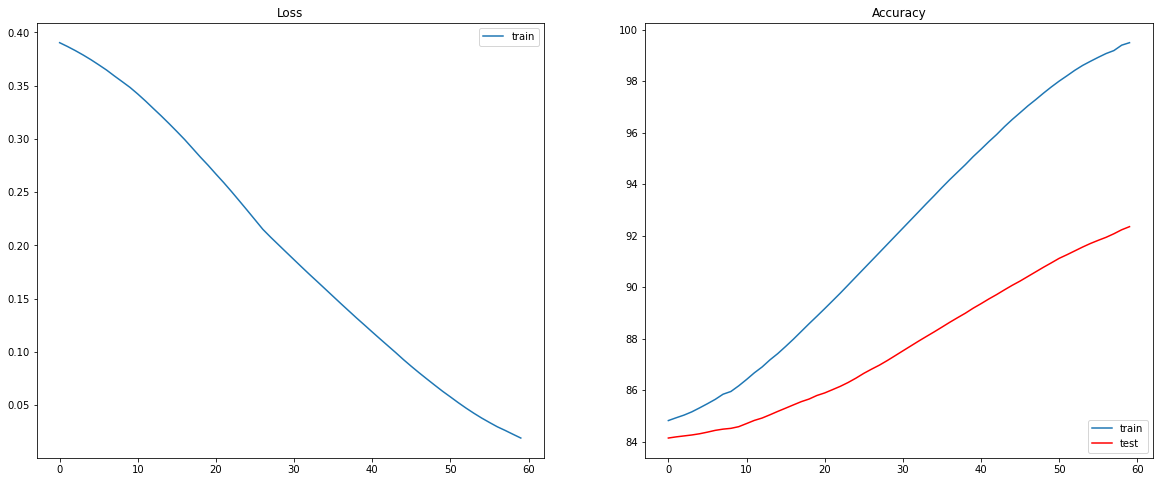

In [29]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,8))
epochs = [e for e in range(num_epochs)]

ax1.set_title('Loss')
ax2.set_title('Accuracy')

ax1.plot(epochs, smooth_h_train[5], label='train')
ax2.plot(epochs, smooth_h_train[4], label='train')
ax2.plot(epochs, smooth_h_test[4], 'r', label='test')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

In [30]:
fig.savefig('training_process.png')

In [31]:
# Predict 
def predict(loader, model, savefig=False):
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            displayImgs(x, predictions, savefig)
            break
    model.train()

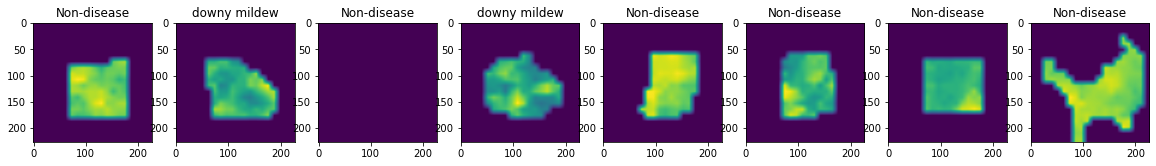

In [32]:
predict(test_loader, model, savefig=True)

In [33]:
torch.save(model.state_dict(), os.getcwd() + "\\downy_mildew_AlexNet_HSI_2.pt")

In [34]:
# Predict 
def predict2(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    model.train()
    
    return actual, prediction

In [35]:
actual, prediction = predict2(test_loader, model)

In [ ]:
print(actual)

In [ ]:
print(prediction)

In [36]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual, prediction)
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

In [37]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cmn, display_labels = ["non-diseased", "diseased"])

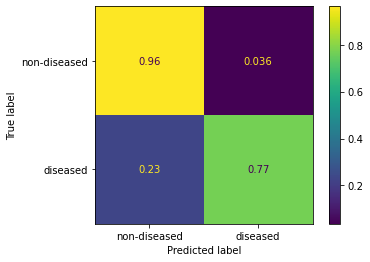

In [38]:
cm_display.plot()
plt.savefig('confusion_matrix.png')
plt.show()